## Visualize velocity fields for each glacier


In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [91]:
import matplotlib.pyplot as plt
from matplotlib import pylab
import numpy as np
import pandas as pd
import matplotlib.ticker as ticker
from osgeo import gdal
import salem
from salem import *

import fiona, rasterio
import geopandas as gpd
from rasterio.plot import show
from rasterio.features import rasterize
from rasterstats import zonal_stats
from sklearn.metrics import mean_squared_error as MSE
import pwlf
import math
from scipy import stats
from scipy.stats import chisquare
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
import statsmodels.api as stm
import statsmodels.formula.api as smf
from hydroeval import *
def cm2inch(*tupl):### plots in cm ##frontiers 180 mm for full width, 85 mm half width (1 column) figures
    inch = 2.54
    if isinstance(tupl[0], tuple):
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)
    

In [166]:
gl = 2# number to select glacier
Glacier = ['Kokanee', 'Conrad', 'Illecillewaet']
glacier = ['kokanee', 'conrad', 'illecillewaet']
path = '/home/pelto/Desktop/lidar_cbt_analysis/' + glacier[gl] + '/'
fl_path = '/home/pelto/Desktop/ice_flux/' + Glacier[gl] + '/'

In [161]:
# VY = '/home/pelto/Desktop/velocity_mapping/kokanee/bedem/3m/img1_20150419__img1_20160417_vmap_5m_51px_spm2/img1_20150419__img1_20160417_vmap_5m_51px_spm2-F_smooth_vy.tif'
# VX = '/home/pelto/Desktop/velocity_mapping/kokanee/bedem/3m/img1_20150419__img1_20160417_vmap_5m_51px_spm2/img1_20150419__img1_20160417_vmap_5m_51px_spm2-F_smooth_vx.tif'
# VY = '/home/pelto/Desktop/velocity_mapping/kokanee/dem/3m/img1_20150912__img1_20160913_vmap_5m_51px_spm2/img1_20150912__img1_20160913_vmap_5m_51px_spm2-F_smooth_vy.tif'
# VX = '/home/pelto/Desktop/velocity_mapping/kokanee/dem/3m/img1_20150912__img1_20160913_vmap_5m_51px_spm2/img1_20150912__img1_20160913_vmap_5m_51px_spm2-F_smooth_vx.tif'
# VX = '/home/pelto/Desktop/velocity_mapping/kokanee/dem/3m/img1_20160417__img1_20170521_vmap_5m_51px_spm2/img1_20160417__img1_20170521_vmap_5m_51px_spm2-F_smooth_vy.tif' 
# VY = '/home/pelto/Desktop/velocity_mapping/kokanee/dem/3m/img1_20160417__img1_20170521_vmap_5m_51px_spm2/img1_20160417__img1_20170521_vmap_5m_51px_spm2-F_smooth_vx.tif'

VY = '/home/pelto/Desktop/velocity_mapping/kokanee/dem/3m/kokanee_vy_25m_2017b.tif'
VX = '/home/pelto/Desktop/velocity_mapping/kokanee/dem/3m/kokanee_vx_25m_2017b.tif'

# VY = '/home/pelto/Desktop/velocity_mapping/kokanee/dem/3m/img1_20170521__img1_20180426_vmap_5m_51px_spm2/img1_20170521__img1_20180426_vmap_5m_51px_spm2-F_smooth_vy.tif'
# VX = '/home/pelto/Desktop/velocity_mapping/kokanee/dem/3m/img1_20170521__img1_20180426_vmap_5m_51px_spm2/img1_20170521__img1_20180426_vmap_5m_51px_spm2-F_smooth_vx.tif'

#'/home/pelto/Desktop/velocity_mapping/kokanee/dem/3m/kokanee_vx_25m_2017.tif'

#YES# '/home/pelto/Desktop/velocity_mapping/kokanee/dem/3m/img1_20170521__img1_20180426_vmap_5m_51px_spm2/img1_20170521__img1_20180426_vmap_5m_51px_spm2-F_smooth_vy.tif'
#YES# '/home/pelto/Desktop/velocity_mapping/kokanee/dem/3m/img1_20160417__img1_20170521_vmap_5m_51px_spm2/img1_20160417__img1_20170521_vmap_5m_51px_spm2-F_smooth_vx.tif'
#YES# /home/pelto/Desktop/velocity_mapping/kokanee/dem/3m/img1_20150912__img1_20160913_vmap_5m_51px_spm2/img1_20150912__img1_20160913_vmap_5m_51px_spm2-F_smooth_vy.tif
#YES#'/home/pelto/Desktop/velocity_mapping/kokanee/dem/3m/img1_20150419__img1_20160417_vmap_5m_51px_spm2/img1_20150419__img1_20160417_vmap_5m_51px_spm2-F_smooth_vx.tif'
#YES#'/home/pelto/src/planet_tools/planet_tools/img1_20170929__img1_20180821_vmap_5m_51px_spm2/img1_20170929__img1_20180821_vmap_5m_51px_spm2-F_smooth_vy.tif'



#MAYBE# /home/pelto/src/planet_tools/planet_tools/img1_20170910__img1_20180821_vmap_5m_51px_spm2/img1_20170910__img1_20180821_vmap_5m_51px_spm2-F_smooth_vy.tif



In [162]:
vy = salem.open_xr_dataset(VY);vy = vy.to_array(name='vy')
vx = salem.open_xr_dataset(VX);vx = vx.to_array(name='vx')
msk = salem.open_xr_dataset(path + 'kokanee_2015_extent_5m.tif')
msk_reproj = vy.salem.transform(msk); msk = msk_reproj.to_array(name='msk')

# vx = salem.open_xr_dataset(VX);;vm = salem.open_xr_dataset(VM)
# vm = vm.to_array(name='vm');#vx = vx.to_array(name='vx');vy = vy.to_array(name='vy')
# vx_reproj = vm.salem.transform(vx);vy_reproj = vm.salem.transform(vy)
# vx = vx_reproj.to_array(name='vx');vy = vy_reproj.to_array(name='vy')

In [163]:
# vy.data[vy.data<0.01]=np.nan
vz = vy
vz.data = np.sqrt(vx.data**2 + vz.data**2 )
vz.data[vz.data<0.01]=np.nan;# vz.data[vz.data>30.0]=vz.data[vz.data>30.0]*0.5 ##remove high erroneous values
vz.data[msk.data!=1.0] = np.nan;

In [164]:
print(np.count_nonzero(~np.isnan(vz.data))/np.count_nonzero(~np.isnan(msk)))
print(np.nanmean(vz[0].data))

0.9982449982449982
4.7934384


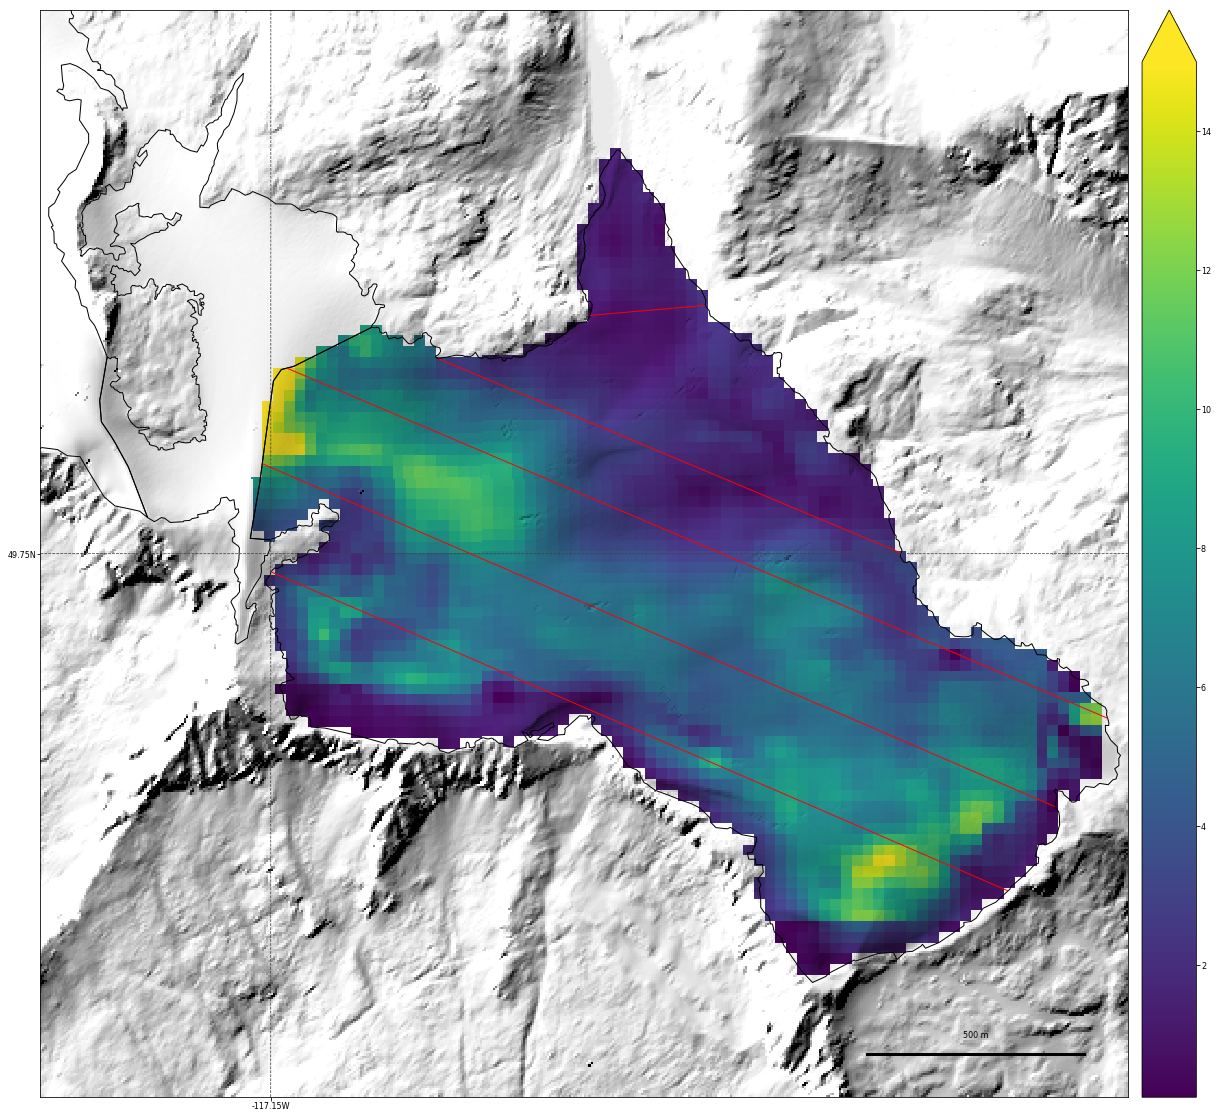

In [165]:
fig, ax = plt.subplots(1,1, sharex=True, sharey=True, figsize=(24,20)) #cm2inch(18, 8.25))
shpf = path + Glacier[gl] + '/kok_all_glaciers_2015_dem.shp' #'/conrad_all_glaciers_2014.shp'
gates = fl_path+'Kok_flux_gates_6.shp'
topo = '/home/pelto/Desktop/lidar_cbt_analysis/kokanee/20181014_Kokanee_dem1_clip_slave.tif'
grid = vy.salem.grid  ##full view
grid = mercator_grid(center_ll=(-117.14, 49.75), extent=(2500, 2500))
sm = Map(grid, countries=False)
sm.set_lonlat_contours(interval=0)
sm.set_scale_bar()
sm.set_data(vy) #, label='m')
sm.set_vmax(val=15.)
#      Change the lon-lat countour setting
sm.set_lonlat_contours(add_ytick_labels=True, interval=0.05, linewidths=0.75, linestyles='--', colors='0.25')
# off_ice_V = np.nanmean(VZ_off_ice)
# print(off_ice_V)
# print(np.nanstd(VZ_off_ice))
# print(np.nanmean(VZ))
gdf = salem.read_shapefile(shpf)
sm.set_shapefile(gdf, linewidth=1)
sm.set_shapefile(gates, linewidth=1, color='r')
sm.set_topography(topo,  relief_factor=0.8)
# sm.set_shapefile(gates, linewidth=1.5, color='r')
# sm.plot(ax=ax)
sm.visualize(ax=ax)
plt.show()

# Conrad

In [82]:
year=2018
vf_list = ['conrad_2016_vy_25m_pos.tif','conrad_2017_vy_25m_pos.tif','conrad_2018_vy_25m_pos_17mos.tif']
vdir = '/home/pelto/Desktop/velocity_mapping/' +Glacier[gl] + '_DEMs/spm2/3m/'
ITS = fl_path + 'ITS_Live/' + str(year) + '_conrad_ITS_LIVE.tif'
I = np.abs(year - 2016) 
### for 2016/7
# VX = vdir+ vf_list[I][:-14] + 'vx_25m.tif' 
# VY = vdir+ vf_list[I]
# VM = vdir+ vf_list[I][:-14] + 'vm_25m.tif'

In [83]:
VY = '/home/pelto/Desktop/velocity_mapping/conrad_planet/img1_20170904__img2_20180822_vmap_5m_51px_spm2/img1_20170904__img2_20180822_vmap_5m_51px_spm2-F_smooth_vy.tif'
VX = '/home/pelto/Desktop/velocity_mapping/conrad_planet/img1_20170904__img2_20180822_vmap_5m_51px_spm2/img1_20170904__img2_20180822_vmap_5m_51px_spm2-F_smooth_vx.tif'

#YES '/home/pelto/Desktop/velocity_mapping/Conrad_DEMs/spm2/3m/img1_20170521__img2_20180426_vmap_5m_51px_spm2/img1_20170521__img2_20180426_vmap_5m_51px_spm2-F_smooth_vx.tif'
#YES '/home/pelto/Desktop/velocity_mapping/Conrad_DEMs/spm2/3m/img1_20160912__img2_20170917_vmap_5m_51px_spm2/img1_20160912__img2_20170917_vmap_5m_51px_spm2-F_smooth_vx.tif'
#YES '/home/pelto/Desktop/velocity_mapping/Conrad_DEMs/spm2/3m/img1_20160417__img1_20170521_vmap_5m_51px_spm2/img1_20160417__img1_20170521_vmap_5m_51px_spm2-F_smooth_vx.tif'
#YES '/home/pelto/Desktop/velocity_mapping/Conrad_DEMs/spm2/3m/img1_20150912__img1_20160912_vmap_5m_51px_spm2/img1_20150912__img1_20160912_vmap_5m_51px_spm2-F_smooth_vx.tif'
#YES /home/pelto/Desktop/velocity_mapping/Conrad_DEMs/spm2/3m/img1_20150420__img1_20160417_vmap_5m_51px_spm2/img1_20150420__img1_20160417_vmap_5m_51px_spm2-F_smooth_vy.tif

In [84]:
vy = salem.open_xr_dataset(VY);vy = vy.to_array(name='vy')
vx = salem.open_xr_dataset(VX);vx = vx.to_array(name='vx')
msk = salem.open_xr_dataset('/home/pelto/Desktop/lidar_cbt_analysis/conrad/conrad_2014_extent_5m.tif') 
dhA_list = ['conrad_2015_2016_dh_dt_filled_1416+50cm.tif', 'conrad_2017_2016_dh_dt_17s14m.tif','conrad_2018_2017_dh_dt.tif']
#'conrad_2016_2017_dh_dt+50cm.tif'

dh_r = path+  dhA_list[I]
dh = salem.open_xr_dataset(dh_r); dh_reproj = vy.salem.transform(dh); dh = dh_reproj.to_array(name='dh')#dh.data[dh.data<1] = np.nan
msk_reproj = vy.salem.transform(msk); msk = msk_reproj.to_array(name='msk')


vz = vy; vz.data = np.sqrt(vx.data**2 + vz.data**2 )
vz.data[vz.data<0.01]=np.nan;# vz.data[vz.data>30.0]=vz.data[vz.data>30.0]*0.5 ##remove high erroneous values
vz.data[msk.data!=1.0] = np.nan;
dh.data[msk.data!=1.0] = np.nan;
np.count_nonzero(~np.isnan(vz.data))/np.count_nonzero(msk)

0.9567617135758898

2018


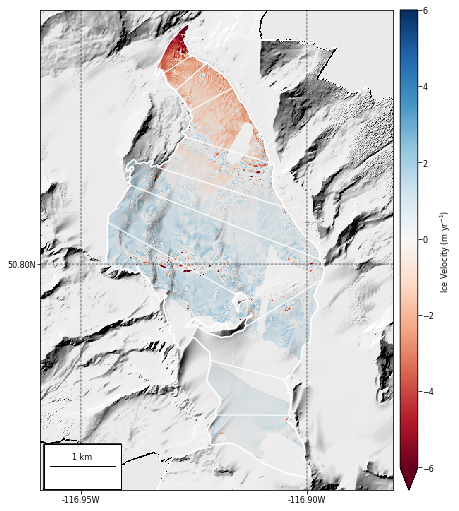

In [85]:
font = {'family' : 'Helvetica', 'weight' : 'normal', 'size'   : 8}
plt.rc('font', **font)
pylab.rcParams['xtick.major.pad']='1'
pylab.rcParams['ytick.major.pad']='1'

fig, ax = plt.subplots(1, figsize=cm2inch(18,24))
topo = '/home/pelto/Desktop/lidar_cbt_analysis/conrad/dem_mosaic_conrad.tif'
grid = mercator_grid(center_ll=(-116.92, 50.802), extent=(5500, 7500)) ##zoomed out view
# grid = mercator_grid(center_ll=(-116.92, 50.81), extent=(7500, 7500))
sm1 = Map(grid, countries=False)
sm1.set_lonlat_contours(interval=0)
sm1.set_scale_bar(location=(0.12, 0.05),add_bbox=True,bbox_dy=1.4,linewidth=1.0)
import xarray as xr
VZA=xr.DataArray(data=vz, coords=vz.coords, dims=vz.dims, name='VZA', attrs=vz.attrs) #,indexes=vx.indexes fastpath=False)

# VZA.data=VZA.data*(msk+1.0)
sm1.set_data(dh) 

# sm1.set_cmap("Spectral_r")
sm1.set_cmap("RdBu")
sm1.set_vmin(val=-6.);sm1.set_vmax(val=6.)
shape = salem.read_shapefile('/home/pelto/Desktop/lidar_cbt_analysis/conrad/Conrad/conrad_16_extent.shp')
gates = salem.read_shapefile('/home/pelto/Desktop/ice_flux/Conrad/conrad_flux_gates_new11.shp')
#      Change the lon-lat countour setting
sm1.set_lonlat_contours(add_ytick_labels=True, interval=0.05, linewidths=0.75, linestyles='--', colors='0.25')
sm1.set_topography(topo,  relief_factor=0.8)
sm1.set_shapefile(shape, lw=1.5, color='w')
sm1.set_shapefile(gates, color='w', lw=1.1)
sm1.append_colorbar(ax=ax, pad=0.1, label='Ice Velocity (m yr$^{-1}$)')#, cbar_title='Ice Velocity (m yr$^-1$)')
sm1.plot(ax=ax)

# u = df_agg.vx.values
# v = df_agg.vy.values

# X, Y = np.meshgrid(df_agg.lon,df_agg.lat)

# # transform their coordinates to the map reference system and plot the arrows
# xx, yy = sm1.grid.transform(df_agg.lon, df_agg.lat, crs=salem.wgs84)#sm1.grid.proj

# # xx, yy = np.meshgrid(xx,yy)

# # qu = ax.quiver(xx, yy, u, v)

# ###### start:stop:step
# Q = ax.quiver(xx[::2], yy[::2], u[::2], v[::2])  #, pivot='mid')
# qk = ax.quiverkey(Q, 0.07, 0.10, 40, r'$40 \frac{m}{a}$', labelpos='N', coordinates='figure', labelsep=0.025)

fig.subplots_adjust(bottom=0.05, top=0.99, left=0.14, right=0.88) #, wspace=0.22, hspace=0.15
# plt.savefig(fl_path+ 'products/'+ glacier[gl]+ '_' +str(year) +'_vel_gates_quiver_2016.pdf', dpi=300)
print(str(year))

# Illecillewaet

In [301]:
# VY = '/home/pelto/Desktop/velocity_mapping/illecillewaet/3m/img1_20170917__img2_20181016_vmap_5m_51px_spm2/img1_20170917__img2_20181016_vmap_5m_51px_spm2-F_smooth_vy.tif'
# VX = '/home/pelto/Desktop/velocity_mapping/illecillewaet/3m/img1_20170917__img2_20181016_vmap_5m_51px_spm2/img1_20170917__img2_20181016_vmap_5m_51px_spm2-F_smooth_vx.tif'

# VX= '/home/pelto/Desktop/velocity_mapping/illecillewaet/3m/img1_20150911__img1_20160912_vmap_5m_51px_spm2/img1_20150911__img1_20160912_vmap_5m_51px_spm2-F_smooth_vx_clean2.tif'
# VY ='/home/pelto/Desktop/velocity_mapping/illecillewaet/3m/img1_20150911__img1_20160912_vmap_5m_51px_spm2/img1_20150911__img1_20160912_vmap_5m_51px_spm2-F_smooth_vy_clean.tif'
# VX='/home/pelto/Desktop/velocity_mapping/illecillewaet/3m/img1_20150419__img1_20160417_vmap_5m_51px_spm2/img1_20150419__img1_20160417_vmap_5m_51px_spm2-F_smooth_vx_clean2.tif'
# VY='/home/pelto/Desktop/velocity_mapping/illecillewaet/3m/img1_20150419__img1_20160417_vmap_5m_51px_spm2/img1_20150419__img1_20160417_vmap_5m_51px_spm2-F_smooth_vy_clean.tif'
# # VX='/home/pelto/Desktop/velocity_mapping/illecillewaet/3m/img1_20160417__img1_20170521_vmap_5m_51px_spm2/img1_20160417__img1_20170521_vmap_5m_51px_spm2-F_smooth_vx_clean2.tif'
# VY='/home/pelto/Desktop/velocity_mapping/illecillewaet/3m/img1_20160417__img1_20170521_vmap_5m_51px_spm2/img1_20160417__img1_20170521_vmap_5m_51px_spm2-F_smooth_vy_clean.tif'
# VX='/home/pelto/Desktop/velocity_mapping/illecillewaet/3m/img1_20170917__img2_20181016_vmap_5m_51px_spm2/img1_20170917__img2_20181016_vmap_5m_51px_spm2-F_smooth_vx.tif'
# VY='/home/pelto/Desktop/velocity_mapping/illecillewaet/3m/img1_20170917__img2_20181016_vmap_5m_51px_spm2/img1_20170917__img2_20181016_vmap_5m_51px_spm2-F_smooth_vy.tif'

VX= '/home/pelto/Desktop/velocity_mapping/illecillewaet/3m/illecillewaet_2016_all25m_vx.tif'
VY= '/home/pelto/Desktop/velocity_mapping/illecillewaet/3m/illecillewaet_2016_all25m_vy.tif'


# /home/pelto/Desktop/velocity_mapping/illecillewaet/illec_planet/img1_20160830__img2_20170822_vmap_5m_51px_spm2/img1_20160830__img2_20170822_vmap_5m_51px_spm2-F_smooth_vx.tif
# /home/pelto/Desktop/velocity_mapping/illecillewaet/illec_planet/img1_20160830__img2_20170911_vmap_5m_51px_spm2/img1_20160830__img2_20170911_vmap_5m_51px_spm2-F_smooth_vx.tif
# /home/pelto/Desktop/velocity_mapping/illecillewaet/3m/img1_20160912__img1_20170917_vmap_5m_51px_spm2/img1_20160912__img1_20170917_vmap_5m_51px_spm2-F_smooth_vx.tif
# /home/pelto/Desktop/velocity_mapping/illecillewaet/3m/img1_20170521__img1_20180426_vmap_5m_51px_spm2/img1_20170521__img1_20180426_vmap_5m_51px_spm2-F_smooth_vx.tif
# /home/pelto/Desktop/velocity_mapping/illecillewaet/3m/img1_20170917__img2_20181016_vmap_5m_51px_spm2/img1_20170917__img2_20181016_vmap_5m_51px_spm2-F_smooth_vx.tif
# /home/pelto/Desktop/velocity_mapping/illecillewaet/illec_planet/img2_20170822__img2_20180822_vmap_5m_51px_spm2/img2_20170822__img2_20180822_vmap_5m_51px_spm2-F_smooth_vx.tif
# /home/pelto/Desktop/velocity_mapping/illecillewaet/illec_planet/img2_20170911__img2_20180822_vmap_5m_51px_spm2/img2_20170911__img2_20180822_vmap_5m_51px_spm2-F_smooth_vx.tif

In [302]:
# year =2017
# I = np.abs(year - 2016) 
# vf_list = ['illecillewaet_2016_all25m_vx.tif','illecillewaet_2017_all25m_vx.tif','illecillewaet_2018_all25m_vx.tif']
# vdir = '/home/pelto/Desktop/velocity_mapping/' +glacier[gl] + '/3m/' 
# VX = vdir+ vf_list[I]
# VY = vdir+ vf_list[I][:-7] + '_vy.tif' 

In [303]:
vy = salem.open_xr_dataset(VY);vy = vy.to_array(name='vy')
vx = salem.open_xr_dataset(VX);vx = vx.to_array(name='vx')
msk = salem.open_xr_dataset(path+'illecillewaet_2014_extent_5m.tif') 
msk_reproj = vy.salem.transform(msk); msk = msk_reproj.to_array(name='msk')
msk.data[msk.data<0.0]=np.nan


vz = vy
vz.data = np.sqrt(vx.data**2 + vz.data**2 )
vz.data[vz.data<0.01]=np.nan;# vy.data[vy.data>50.0]=np.nan
vz.data[msk.data!=1.0] = np.nan;
np.count_nonzero(~np.isnan(vz.data))/np.count_nonzero(~np.isnan(msk))

0.9892978757904978

In [304]:
np.nanmean(vz)

13.889623

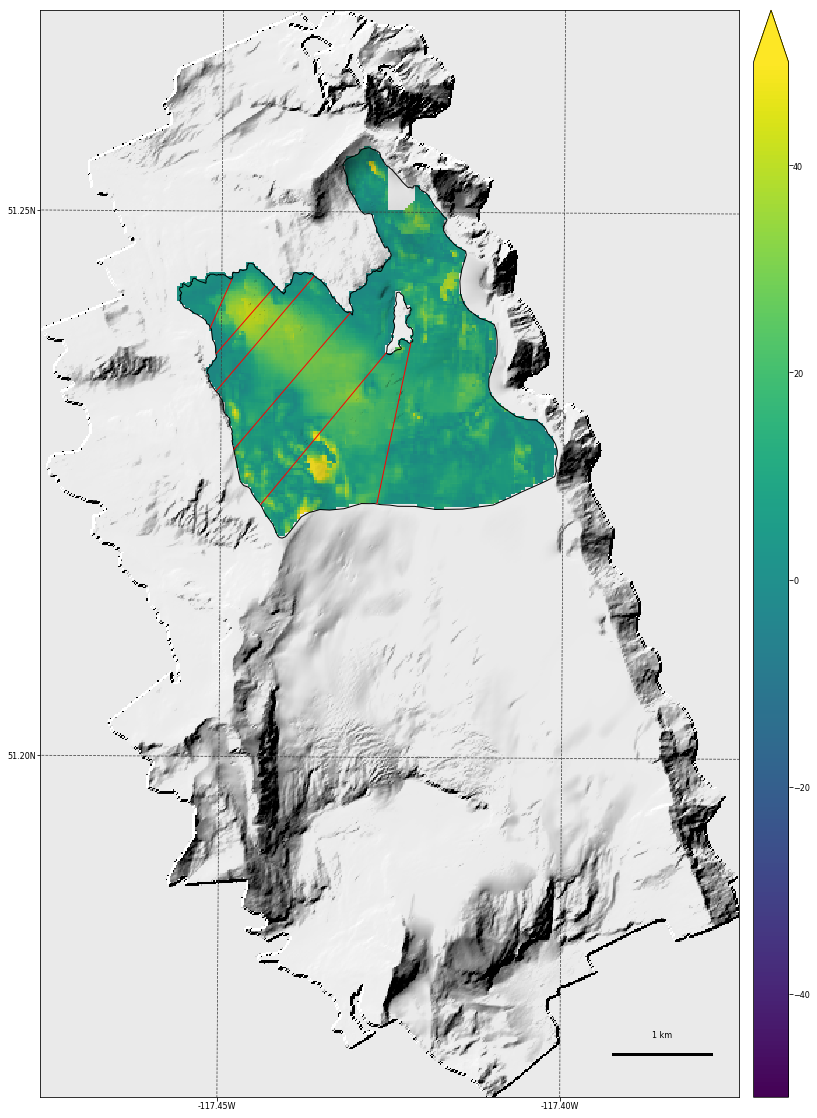

In [306]:
fig, ax = plt.subplots(1,1, sharex=True, sharey=True, figsize=(20,20)) #cm2inch(18, 8.25))
pts_file = fl_path + 'Illec_flux_gates_5_pts_20m.shp'  ##must be WGS84 currently
gates = fl_path+'Illec_flux_gates_5.shp'
shpf = '/home/pelto/GIS/outlines/Illec2016.shp'   
topo = path + '160912_illecillewaet_dem1_clip_master.tif'
grid = vy.salem.grid  ##full view
# grid = mercator_grid(center_ll=(-117.43, 51.238), extent=(4500, 4500)) ##zoomed out view
sm = Map(grid, countries=False)
sm.set_lonlat_contours(interval=0)
# sm.set_cmap("RdBu")
sm.set_scale_bar()
sm.set_data(vz) #, label='m')
sm.set_vmax(val=50.);sm.set_vmin(val=-50.)
#      Change the lon-lat countour setting
sm.set_lonlat_contours(add_ytick_labels=True, interval=0.05, linewidths=0.75, linestyles='--', colors='0.25')
# off_ice_V = np.nanmean(VZ_off_ice)
# print(off_ice_V)
# print(np.nanstd(VZ_off_ice))
# print(np.nanmean(VZ))
gdf = salem.read_shapefile(shpf)
sm.set_shapefile(gdf, linewidth=1)
sm.set_shapefile(gates, linewidth=1, color='r')
sm.set_topography(topo,  relief_factor=0.8)
# sm.set_shapefile(gates, linewidth=1.5, color='r')
# sm.plot(ax=ax)
sm.visualize(ax=ax)
plt.show()

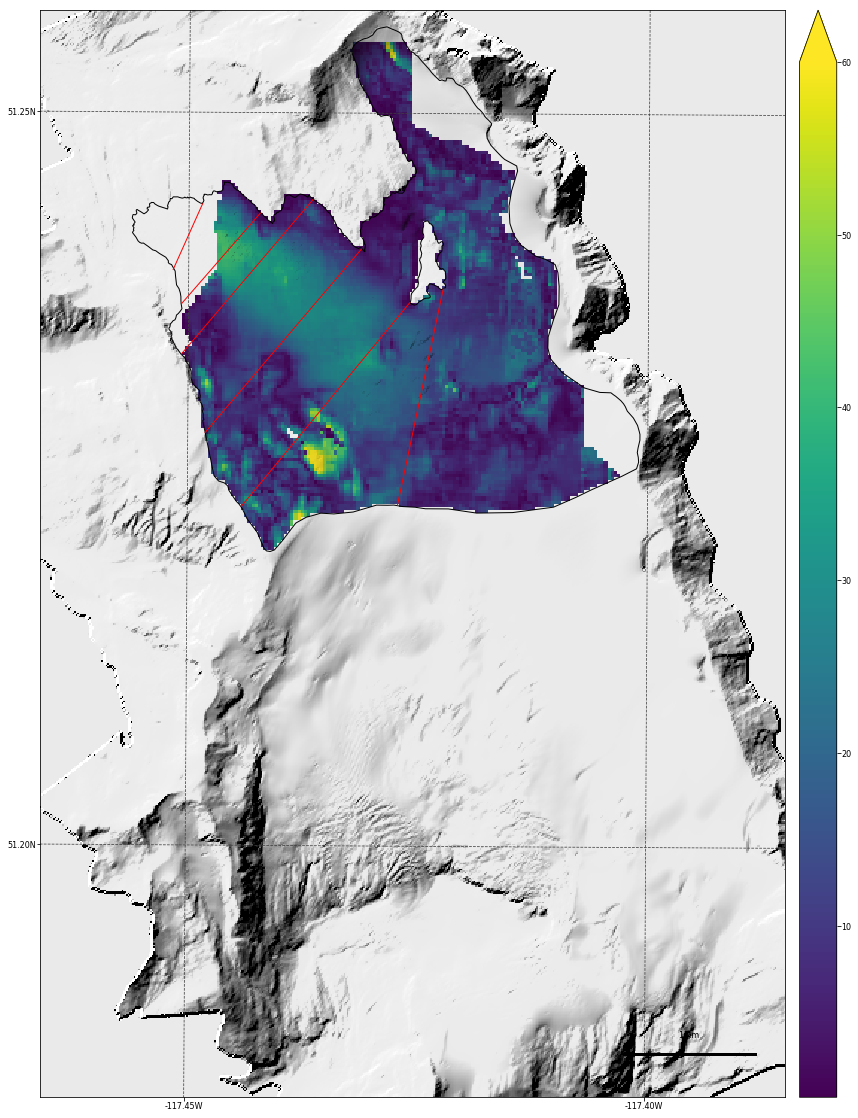

In [297]:
fig, ax = plt.subplots(1,1, sharex=True, sharey=True, figsize=(20,20)) #cm2inch(18, 8.25))
pts_file = fl_path + 'Illec_flux_gates_16_pts_20m_new.shp'  ##must be WGS84 currently
gates = fl_path+'Illec_flux_gates_new.shp'
shpf = '/home/pelto/GIS/outlines/Illec2016.shp'   
topo = path + '160912_illecillewaet_dem1_clip_master.tif'
grid = vy.salem.grid  ##full view
# grid = mercator_grid(center_ll=(-117.43, 51.238), extent=(4500, 4500)) ##zoomed out view
sm = Map(grid, countries=False)
sm.set_lonlat_contours(interval=0)
sm.set_scale_bar()
sm.set_data(vz) #, label='m')
sm.set_vmax(val=60.)
#      Change the lon-lat countour setting
sm.set_lonlat_contours(add_ytick_labels=True, interval=0.05, linewidths=0.75, linestyles='--', colors='0.25')
# off_ice_V = np.nanmean(VZ_off_ice)
# print(off_ice_V)
# print(np.nanstd(VZ_off_ice))
# print(np.nanmean(VZ))
gdf = salem.read_shapefile(shpf)
sm.set_shapefile(gdf, linewidth=1)
sm.set_shapefile(gates, linewidth=1, color='r')
sm.set_topography(topo,  relief_factor=0.8)
# sm.set_shapefile(gates, linewidth=1.5, color='r')
# sm.plot(ax=ax)
sm.visualize(ax=ax)
plt.show()